# Classifiers - NC - busy vs relaxed - no TFv1
Exploring different classifiers with different autoencoders for the NC task. No contractive autoencoder because it needs TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Undercomplete Autoencoder](#Undercomplete-Autoencoder)  
[Sparse Autoencoder](#Sparse-Autoencoder)  
[Deep Autoencoder](#Deep-Autoencoder)  

classifiers:  
[Simple dense classifier](#Simple-dense-classifier)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

In [2]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [3]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 before starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [4]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [5]:
def get_busy_vs_relax_timeframes_br_hb(path, ident, seconds):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1)."""
    
    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))

        if cog_res['task_label'][task_num_table] != 'NC':
            continue
        
        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)

        try:

            # get extracted features for breathing
            tmpBR_busy = dataextract.extract_from_breathing_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpBR_relax = dataextract_relax.extract_from_breathing_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])
            #get extracted features for heartbeat
            tmpHB_busy = dataextract.extract_from_heartbeat_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpHB_relax = dataextract.extract_from_heartbeat_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])

            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tasks_y, 1))
            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tmp_tasks_y, 0))

            # put busy frames then relaxed frames under the previous frames
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        except ValueError:
#             print(ident)  # ignore short windows
            continue

        # put busy frames then relaxed frames under the previous frames
        tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 1))
        tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 0))

        breathing = np.vstack((breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        breathing = np.vstack((breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        heartbeat = np.vstack((heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        heartbeat = np.vstack((heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

    return tasks_data, tasks_y, breathing, heartbeat

In [6]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes

            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [7]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [8]:
def clear_session_and_set_seeds():
    # clear session and set seeds again
    K.clear_session()
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [9]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [10]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [11]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [12]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [13]:
# AE Training params
batch_size = 128
epochs = 1000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [14]:
def compare_plot_n(data1, data2, plot_n=10):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 5, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 5, i+1)
        plt.plot(data2[i])

#### Undercomplete Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [15]:
def undercomplete_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42)(input_data)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    autoencoder = Model(input_data, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [16]:
clear_session_and_set_seeds()
uc_ae, uc_enc = undercomplete_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
uc_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

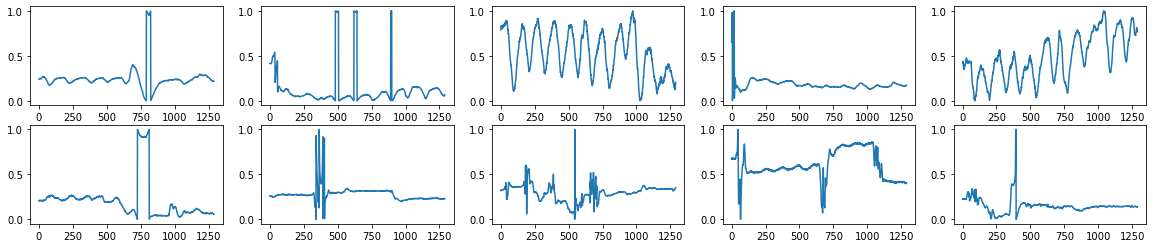

<Figure size 432x288 with 0 Axes>

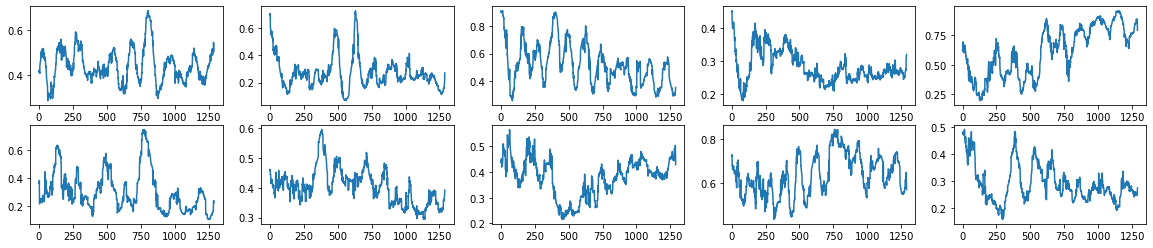

In [17]:
data2 = uc_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

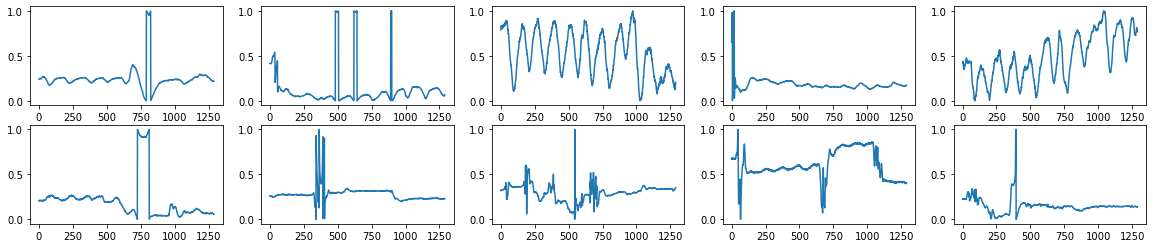

<Figure size 432x288 with 0 Axes>

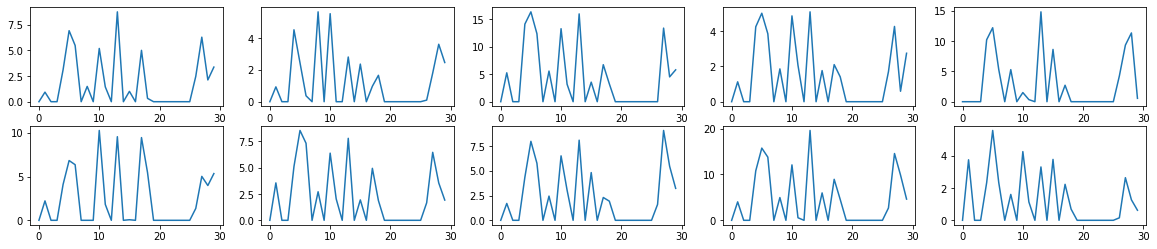

In [18]:
data2 = uc_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Store the encoded representations in the data dictionary:

In [19]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    uc_data = uc_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['undercomplete_encoded'] = uc_data

#### Sparse Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [20]:
def sparse_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42) (input_data)
    # "encoded" is the encoded representation of the input
    # add a sparsity constraint
    encoded = Dense(encoding_dim, activation='relu', name="encoded",
                    activity_regularizer=regularizers.l1(10e-5))(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [21]:
clear_session_and_set_seeds()
sp_ae, sp_enc = sparse_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
sp_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

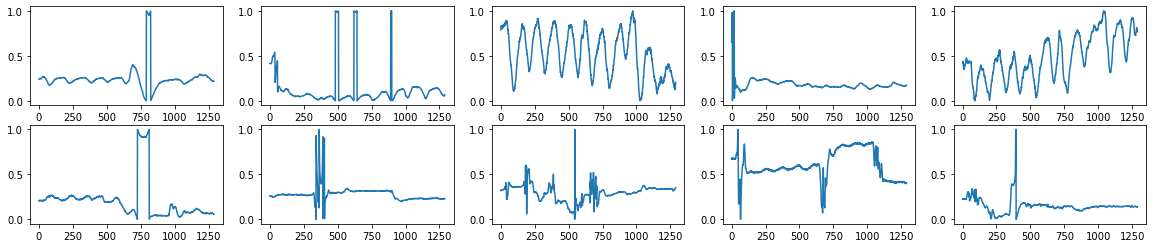

<Figure size 432x288 with 0 Axes>

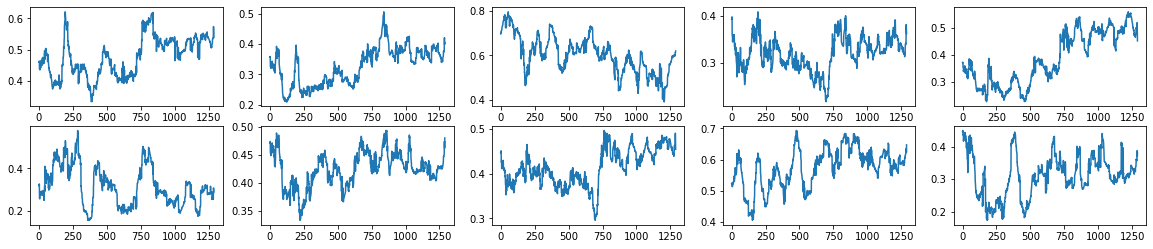

In [22]:
data2 = sp_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

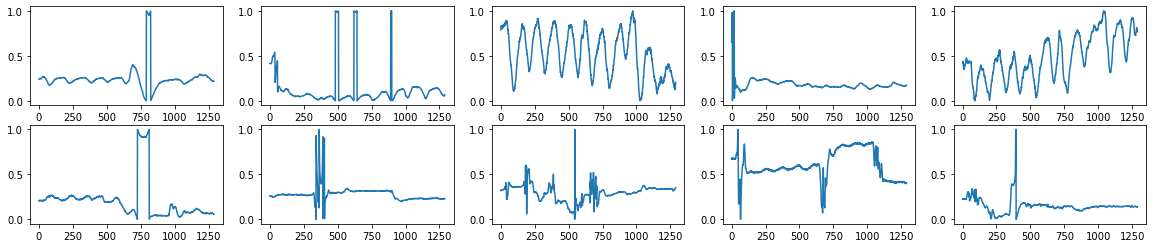

<Figure size 432x288 with 0 Axes>

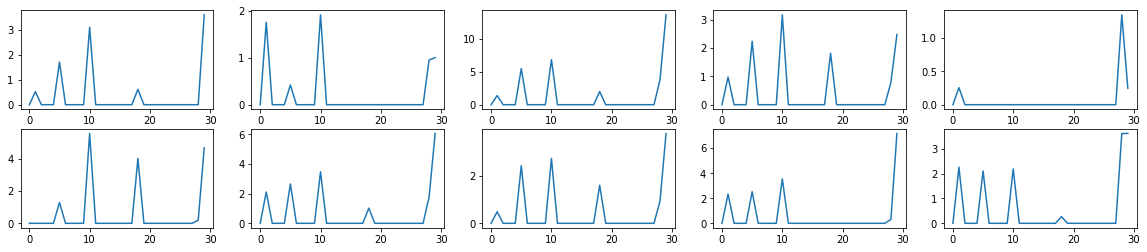

In [23]:
data2 = sp_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Store the encoded representations in the data dictionary:

In [24]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    sp_data = sp_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['sparse_encoded'] = sp_data

#### Deep Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [25]:
def deep_ae(x, enc_layers=[512,128], encoding_dim=64, dec_layers=[128,512], encoded_as_model=False):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    input_data = keras.Input(shape=x[0].shape, name="normalized_signal")
    model = Dropout(0.125, name="dropout", autocast=False, seed=42)(input_data)
    for i in enumerate(enc_layers):
        model = Dense(i[1], activation="relu", name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(encoding_dim, activation="relu", name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(dec_layers[0], activation="sigmoid", name="dense_dec_1")(encoded_output)
    for i in enumerate(dec_layers[1:]):
        model = Dense(i[1], activation="sigmoid", name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x[0].shape[0], activation="sigmoid", name="reconstructed_signal")(model)
    
    autoencoder = Model(input_data, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)

    return autoencoder, encoded

Train autoencoder on data:

In [26]:
clear_session_and_set_seeds()
de_ae, de_enc = deep_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
de_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

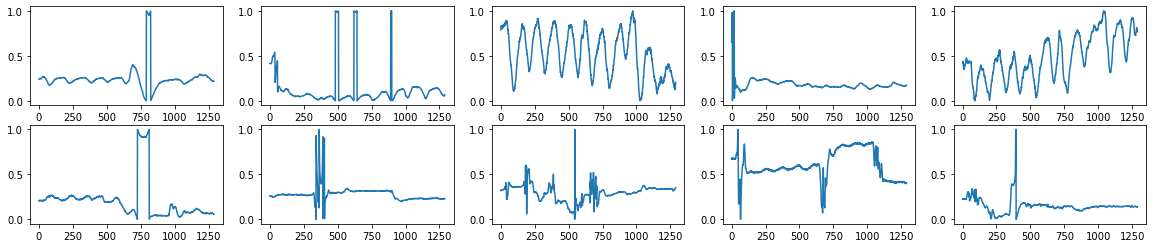

<Figure size 432x288 with 0 Axes>

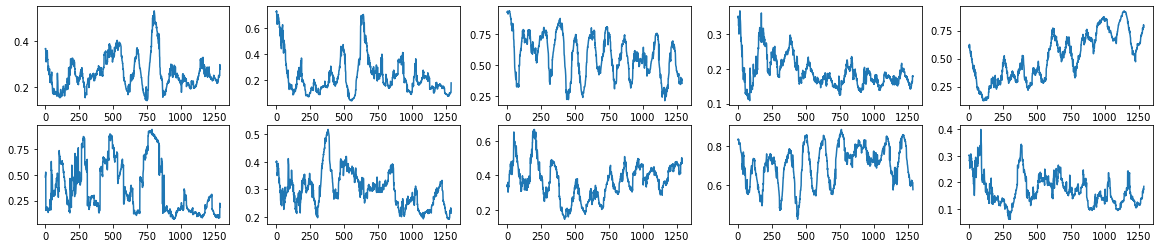

In [27]:
data2 = de_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

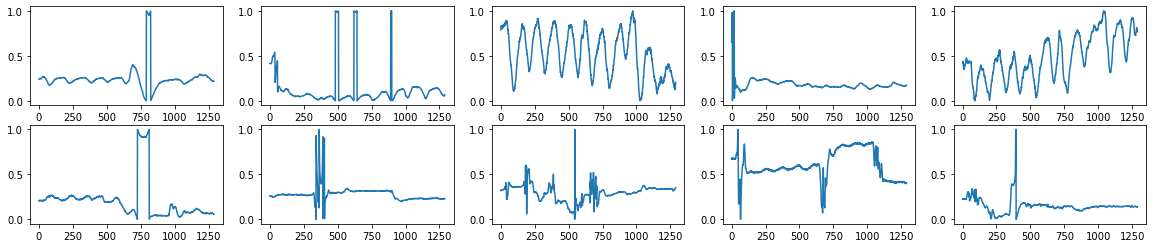

<Figure size 432x288 with 0 Axes>

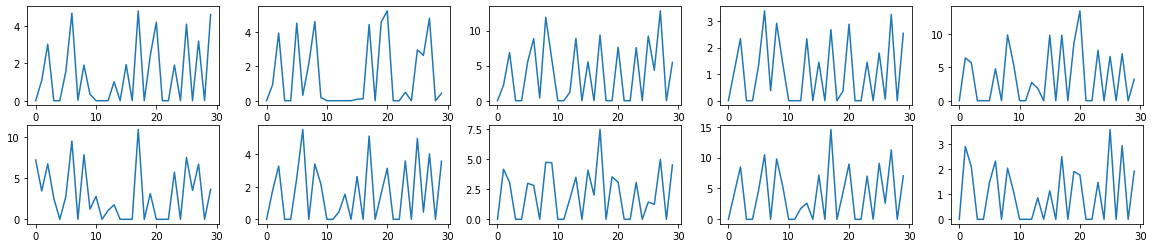

In [28]:
data2 = de_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Store the encoded representations in the data dictionary:

In [29]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    de_data = de_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['deep_encoded'] = de_data

Helper function to get data from the dictionary:

In [30]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    breathing = breathing_shape.copy()
    heartbeat = heartbeat_shape.copy()
    combined = combined_shape.copy()
    undercomplete_encoded = ae_encoded_shape.copy()
    sparse_encoded = ae_encoded_shape.copy()
    deep_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        y = np.vstack((y, data_dict[tmp_id]['y']))
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        breathing = np.vstack((breathing, data_dict[tmp_id]['breathing']))
        heartbeat = np.vstack((heartbeat, data_dict[tmp_id]['heartbeat']))
        combined = np.vstack((combined, data_dict[tmp_id]['combined']))
        undercomplete_encoded = np.vstack((undercomplete_encoded, data_dict[tmp_id]['undercomplete_encoded']))
        sparse_encoded = np.vstack((sparse_encoded, data_dict[tmp_id]['sparse_encoded']))
        deep_encoded = np.vstack((deep_encoded, data_dict[tmp_id]['deep_encoded']))
    
    return y, phase, breathing, heartbeat, combined, undercomplete_encoded, sparse_encoded, deep_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [31]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['breathing'] = []
    accs['heartbeat'] = []
    accs['combined br hb'] = []
    accs['undercomplete'] = []
    accs['sparse'] = []
    accs['deep'] = []
    accs['test id'] = []
    start_time = datetime.now()

    # leave out person out validation
    for i in range(n):
        
        # print current iteration and time elapsed from start
        print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

        ## ----- Data preparation:
        validation_idents = [idents[i]]
        test_idents = [idents[i-1]]
        
        train_idents = []
        for ident in idents:
            if (ident not in test_idents) and (ident not in validation_idents):
                train_idents.append(ident)

        # save test id to see which id yielded which accuracies
        accs['test id'].append(test_idents[0])

        # Load train data
        train_data = get_ident_data_from_dict(train_idents, data_dict)
        y_train = train_data[0]
        
        # Load validation data
        valid_data = get_ident_data_from_dict(validation_idents, data_dict)
        y_valid = valid_data[0]

        # Load test data
        test_data = get_ident_data_from_dict(test_idents, data_dict)
        y_test = test_data[0]
        
        data_names_by_index = ['y', 'phase', 'breathing', 'heartbeat',
                                   'combined br hb', 'undercomplete', 'sparse', 'deep']

        # Loop over all data that will be used for classification and send it to the classifier
        # index 0 is y so we skip it
        for index in range(1, len(test_data)):
            clear_session_and_set_seeds()
            train_x = train_data[index]
            valid_x = valid_data[index]
            test_x = test_data[index]
            
            # Scale data
            if should_scale_data:
                # Scale with standard scaler
                sscaler = StandardScaler()
                sscaler.fit(train_x)
                train_x = sscaler.transform(train_x)

                # Scale valid and test with train's scaler
                valid_x = sscaler.transform(valid_x)
                test_x = sscaler.transform(test_x)
            
            # Initialize variables
            tmp_acc = []
            data_name = data_names_by_index[index]
            
            for tmp_index in range(num_loops_to_average_over):
                curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                tmp_acc.append(curr_acc)
            
            # Store accuracy
            curr_acc = np.mean(tmp_acc)
            accs[data_name].append(curr_acc)
        

    # Print total time required to run this
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [32]:
params_dense_phase = {
    'dropout': 0.4,
    'hidden_size': 26,
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 300
}

In [33]:
params_dense_br_hb = {
    'dropout': 0.05,
    'hidden_size': 24,
    'activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.05,
    'batch_size': 128,
    'epochs': 100
}

In [34]:
params_dense_ae_enc = {
    'dropout': 0.05,
    'hidden_size': 34,
    'activation': 'relu',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'learning_rate': 0.005,
    'batch_size': 106,
    'epochs': 200
}

In [35]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_dense_br_hb
    if (data_name == 'phase'):
        params = params_dense_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_dense_ae_enc
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['hidden_size']))
    model.add(Activation(params['activation']))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [36]:
accs = helper_loop(dense_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:24.687703
iteration: 3 of 23 ; time elapsed: 0:00:47.919616
iteration: 4 of 23 ; time elapsed: 0:01:11.051646
iteration: 5 of 23 ; time elapsed: 0:01:34.666966
iteration: 6 of 23 ; time elapsed: 0:01:58.230821
iteration: 7 of 23 ; time elapsed: 0:02:21.753593
iteration: 8 of 23 ; time elapsed: 0:02:44.941409
iteration: 9 of 23 ; time elapsed: 0:03:07.801791
iteration: 10 of 23 ; time elapsed: 0:03:30.171560
iteration: 11 of 23 ; time elapsed: 0:03:52.980396
iteration: 12 of 23 ; time elapsed: 0:04:17.158716
iteration: 13 of 23 ; time elapsed: 0:04:39.469005
iteration: 14 of 23 ; time elapsed: 0:05:01.356453
iteration: 15 of 23 ; time elapsed: 0:05:23.211439
iteration: 16 of 23 ; time elapsed: 0:05:45.590799
iteration: 17 of 23 ; time elapsed: 0:06:07.680138
iteration: 18 of 23 ; time elapsed: 0:06:29.482118
iteration: 19 of 23 ; time elapsed: 0:06:51.529480
iteration: 20 of 23 ; time elapsed: 0:07:13.484

In [37]:
accuracies['simple_dense'] = accs

In [38]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.500000,0.250000,0.250000,0.250000,0.750000,0.750000,0.500000,62i9y
1,0.833333,0.666667,0.333333,0.666667,0.666667,0.666667,0.500000,2gu87
2,0.833333,0.666667,0.833333,0.833333,1.000000,0.666667,1.000000,iz2ps
3,0.500000,0.666667,0.333333,0.666667,0.666667,0.666667,0.666667,1mpau
4,0.500000,0.833333,0.666667,0.500000,0.666667,0.500000,0.833333,7dwjy
5,0.666667,0.833333,0.166667,1.000000,0.500000,0.833333,0.500000,7swyk
6,0.666667,0.500000,0.500000,0.666667,0.500000,0.666667,0.666667,94mnx
7,0.833333,0.666667,0.500000,0.666667,0.833333,0.666667,1.000000,bd47a
8,0.500000,0.666667,0.500000,0.833333,0.500000,0.333333,0.333333,c24ur
9,0.666667,0.833333,0.333333,0.666667,1.000000,0.666667,0.666667,ctsax


In [39]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.333333   0.250000   0.166667        0.250000       0.333333  0.333333  0.333333
max     0.833333   1.000000   1.000000        1.000000       1.000000  1.000000  1.000000
mean    0.615942   0.677536   0.554348        0.699275       0.670290  0.663043  0.673913
median  0.666667   0.666667   0.500000        0.666667       0.666667  0.666667  0.666667


#### LSTM-based classifier  
based on the original author's code

In [40]:
params_lstm_phase = {
    'kernel_size': 4,
    'filters': 32,
    'strides': 2,
    'pool_size': 4,
    'dropout': 0.1,
    'lstm_output_size': 22,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.005,
    'batch_size': 168,
    'epochs': 200
}

In [41]:
params_lstm_br_hb = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 1,
    'dropout': 0.01,
    'lstm_output_size': 64,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [42]:
params_lstm_ae_enc = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.01,
    'lstm_output_size': 32,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [43]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_lstm_br_hb
    if (data_name == 'phase'):
        params = params_lstm_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_lstm_ae_enc
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [44]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:43.527648
iteration: 3 of 23 ; time elapsed: 0:01:25.733041
iteration: 4 of 23 ; time elapsed: 0:02:10.551548
iteration: 5 of 23 ; time elapsed: 0:03:02.795116
iteration: 6 of 23 ; time elapsed: 0:03:57.047217
iteration: 7 of 23 ; time elapsed: 0:04:53.579155
iteration: 8 of 23 ; time elapsed: 0:05:47.227341
iteration: 9 of 23 ; time elapsed: 0:06:41.678571
iteration: 10 of 23 ; time elapsed: 0:07:36.456505
iteration: 11 of 23 ; time elapsed: 0:08:29.778519
iteration: 12 of 23 ; time elapsed: 0:09:29.478405
iteration: 13 of 23 ; time elapsed: 0:10:22.233957
iteration: 14 of 23 ; time elapsed: 0:11:10.951944
iteration: 15 of 23 ; time elapsed: 0:11:55.453869
iteration: 16 of 23 ; time elapsed: 0:12:40.129035
iteration: 17 of 23 ; time elapsed: 0:13:24.531953
iteration: 18 of 23 ; time elapsed: 0:14:13.864750
iteration: 19 of 23 ; time elapsed: 0:15:04.575485
iteration: 20 of 23 ; time elapsed: 0:15:52.605

In [45]:
accuracies['LSTM'] = accs

In [46]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.250000,0.500000,0.000000,0.500000,0.250000,0.250000,0.500000,62i9y
1,0.833333,0.666667,0.500000,0.666667,0.666667,0.333333,0.333333,2gu87
2,1.000000,1.000000,0.666667,0.833333,1.000000,0.500000,0.666667,iz2ps
3,0.666667,0.666667,0.166667,0.833333,0.500000,0.500000,0.500000,1mpau
4,0.833333,0.666667,0.333333,0.833333,0.833333,0.666667,0.833333,7dwjy
5,0.500000,0.833333,0.500000,1.000000,0.500000,0.833333,0.500000,7swyk
6,0.833333,0.666667,0.333333,0.666667,0.333333,0.333333,0.666667,94mnx
7,1.000000,0.500000,0.666667,0.833333,0.833333,0.666667,0.833333,bd47a
8,0.500000,1.000000,0.500000,0.833333,0.333333,0.333333,0.500000,c24ur
9,0.833333,0.666667,0.166667,0.333333,0.666667,0.500000,0.833333,ctsax


In [47]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.250000   0.333333   0.000000        0.333333       0.250000  0.166667  0.166667
max     1.000000   1.000000   0.833333        1.000000       1.000000  0.833333  1.000000
mean    0.713768   0.666667   0.528986        0.695652       0.576087  0.481884  0.594203
median  0.833333   0.666667   0.500000        0.666667       0.500000  0.500000  0.666667


#### kNN

In [48]:
params_knn_phase = {
    'n_neighbors': 5,
    'metric': 'cosine'
}

In [49]:
params_knn_br_hb = {
    'n_neighbors': 15,
    'metric': 'manhattan'
}

In [50]:
params_knn_ae_enc = {
    'n_neighbors': 15,
    'metric': 'cosine'
}

In [51]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier(params):
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    return model

In [52]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_knn_br_hb
    if (data_name == 'phase'):
        params = params_knn_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_knn_ae_enc
    
    model = KNN_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [53]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.057872
iteration: 3 of 23 ; time elapsed: 0:00:00.096742
iteration: 4 of 23 ; time elapsed: 0:00:00.131673
iteration: 5 of 23 ; time elapsed: 0:00:00.167553
iteration: 6 of 23 ; time elapsed: 0:00:00.205452
iteration: 7 of 23 ; time elapsed: 0:00:00.240381
iteration: 8 of 23 ; time elapsed: 0:00:00.275294
iteration: 9 of 23 ; time elapsed: 0:00:00.311169
iteration: 10 of 23 ; time elapsed: 0:00:00.348069
iteration: 11 of 23 ; time elapsed: 0:00:00.384001
iteration: 12 of 23 ; time elapsed: 0:00:00.419904
iteration: 13 of 23 ; time elapsed: 0:00:00.453786
iteration: 14 of 23 ; time elapsed: 0:00:00.490217
iteration: 15 of 23 ; time elapsed: 0:00:00.524096
iteration: 16 of 23 ; time elapsed: 0:00:00.558029
iteration: 17 of 23 ; time elapsed: 0:00:00.596678
iteration: 18 of 23 ; time elapsed: 0:00:00.634576
iteration: 19 of 23 ; time elapsed: 0:00:00.670480
iteration: 20 of 23 ; time elapsed: 0:00:00.705

In [54]:
accuracies['kNN'] = accs

In [55]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.500000,0.250000,0.250000,0.500000,0.500000,0.500000,0.250000,62i9y
1,0.833333,0.666667,0.500000,0.833333,0.500000,0.500000,0.333333,2gu87
2,0.666667,0.833333,0.333333,0.833333,0.666667,0.500000,0.666667,iz2ps
3,0.666667,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1mpau
4,0.666667,0.666667,0.500000,0.666667,0.500000,0.500000,0.833333,7dwjy
5,0.500000,1.000000,0.333333,1.000000,0.500000,0.500000,0.500000,7swyk
6,0.500000,0.666667,0.666667,0.500000,0.500000,0.333333,0.500000,94mnx
7,0.833333,0.833333,0.500000,0.833333,0.833333,0.666667,1.000000,bd47a
8,0.333333,0.500000,0.666667,0.666667,0.333333,0.333333,0.333333,c24ur
9,0.666667,0.833333,0.500000,0.833333,0.666667,0.500000,0.500000,ctsax


In [56]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.333333   0.166667   0.250000        0.500000       0.333333  0.166667  0.166667
max     0.833333   1.000000   0.833333        1.000000       1.000000  1.000000  1.000000
mean    0.630435   0.692029   0.496377        0.746377       0.586957  0.543478  0.532609
median  0.666667   0.666667   0.500000        0.666667       0.500000  0.500000  0.500000


####  SVC

In [57]:
params_svc_phase = {
    'C': 10,
    'kernel': 'rbf',
    'gamma': 'scale'
}

In [58]:
params_svc_br_hb = {
    'C': 2,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [59]:
params_svc_ae_enc = {
    'C': 3,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [60]:
from sklearn.svm import SVC

def SVC_classifier(params):
    model = SVC(random_state=42, C=params['C'], kernel=params['kernel'], gamma=params['gamma'])
    return model

In [61]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_svc_br_hb
    if (data_name == 'phase'):
        params = params_svc_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_svc_ae_enc
    
    model = SVC_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [62]:
accs = helper_loop(SVC_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.058870
iteration: 3 of 23 ; time elapsed: 0:00:00.117713
iteration: 4 of 23 ; time elapsed: 0:00:00.176529
iteration: 5 of 23 ; time elapsed: 0:00:00.236367
iteration: 6 of 23 ; time elapsed: 0:00:00.292246
iteration: 7 of 23 ; time elapsed: 0:00:00.351061
iteration: 8 of 23 ; time elapsed: 0:00:00.410901
iteration: 9 of 23 ; time elapsed: 0:00:00.470740
iteration: 10 of 23 ; time elapsed: 0:00:00.527588
iteration: 11 of 23 ; time elapsed: 0:00:00.584465
iteration: 12 of 23 ; time elapsed: 0:00:00.642309
iteration: 13 of 23 ; time elapsed: 0:00:00.699129
iteration: 14 of 23 ; time elapsed: 0:00:00.756975
iteration: 15 of 23 ; time elapsed: 0:00:00.820804
iteration: 16 of 23 ; time elapsed: 0:00:00.879646
iteration: 17 of 23 ; time elapsed: 0:00:00.936494
iteration: 18 of 23 ; time elapsed: 0:00:00.991886
iteration: 19 of 23 ; time elapsed: 0:00:01.050726
iteration: 20 of 23 ; time elapsed: 0:00:01.110

In [63]:
accuracies['SVC'] = accs

In [64]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.750000,0.500000,0.000000,0.250000,0.500000,0.500000,0.750000,62i9y
1,0.666667,0.666667,0.500000,0.666667,0.500000,0.500000,0.333333,2gu87
2,1.000000,1.000000,0.500000,0.833333,0.833333,0.500000,0.666667,iz2ps
3,0.500000,0.666667,0.500000,0.500000,0.500000,0.500000,0.333333,1mpau
4,0.833333,0.666667,0.666667,0.666667,0.666667,0.666667,0.833333,7dwjy
5,0.500000,1.000000,0.500000,1.000000,0.500000,0.500000,0.500000,7swyk
6,0.666667,0.833333,0.333333,0.500000,0.333333,0.666667,0.333333,94mnx
7,0.833333,0.833333,0.500000,0.666667,0.833333,0.833333,1.000000,bd47a
8,0.333333,0.666667,0.666667,0.833333,0.333333,0.333333,0.333333,c24ur
9,0.833333,0.666667,0.333333,0.833333,0.833333,0.666667,0.500000,ctsax


In [65]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.333333   0.333333   0.000000        0.250000       0.333333  0.166667  0.333333
max     1.000000   1.000000   0.833333        1.000000       1.000000  0.833333  1.000000
mean    0.655797   0.717391   0.528986        0.692029       0.659420  0.586957  0.554348
median  0.666667   0.666667   0.500000        0.666667       0.666667  0.666667  0.500000


#### Random Forest

In [66]:
params_rf_phase = {
    'n_estimators': 180,
    'max_depth': 50,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'oob_score': False,
    'ccp_alpha': 0.001
}

In [67]:
params_rf_br_hb = {
    'n_estimators': 180,
    'max_depth': None,
    'min_samples_split': 3,
    'min_samples_leaf': 3,
    'oob_score': False,
    'ccp_alpha': 0.005
}

In [68]:
params_rf_ae_enc = {
    'n_estimators': 130,
    'max_depth': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'oob_score': True,
    'ccp_alpha': 0.005
}

In [69]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(params):
    model = RandomForestClassifier(random_state=42,
                                   n_estimators = params['n_estimators'],
                                   criterion = 'entropy',
                                   max_depth = params['max_depth'],
                                   min_samples_split = params['min_samples_split'],
                                   min_samples_leaf = params['min_samples_leaf'],
                                   oob_score = params['oob_score'],
                                   ccp_alpha = params['ccp_alpha'],
                                   max_features = 'log2',
                                   bootstrap = True)
    return model

In [70]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_rf_br_hb
    if (data_name == 'phase'):
        params = params_rf_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_rf_ae_enc
    
    model = random_forest_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [71]:
accs = helper_loop(random_forest_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:02.011617
iteration: 3 of 23 ; time elapsed: 0:00:04.031809
iteration: 4 of 23 ; time elapsed: 0:00:06.002627
iteration: 5 of 23 ; time elapsed: 0:00:07.991110
iteration: 6 of 23 ; time elapsed: 0:00:09.992838
iteration: 7 of 23 ; time elapsed: 0:00:11.994378
iteration: 8 of 23 ; time elapsed: 0:00:13.995593
iteration: 9 of 23 ; time elapsed: 0:00:15.976675
iteration: 10 of 23 ; time elapsed: 0:00:17.941247
iteration: 11 of 23 ; time elapsed: 0:00:19.912798
iteration: 12 of 23 ; time elapsed: 0:00:21.892554
iteration: 13 of 23 ; time elapsed: 0:00:23.902229
iteration: 14 of 23 ; time elapsed: 0:00:25.886590
iteration: 15 of 23 ; time elapsed: 0:00:27.869217
iteration: 16 of 23 ; time elapsed: 0:00:29.853710
iteration: 17 of 23 ; time elapsed: 0:00:31.844295
iteration: 18 of 23 ; time elapsed: 0:00:33.870197
iteration: 19 of 23 ; time elapsed: 0:00:35.865260
iteration: 20 of 23 ; time elapsed: 0:00:37.861

In [72]:
accuracies['random_forest'] = accs

In [73]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.500000,0.500000,0.500000,0.500000,0.250000,0.250000,0.250000,62i9y
1,0.333333,0.666667,0.666667,0.666667,0.666667,0.666667,0.333333,2gu87
2,0.833333,1.000000,0.500000,1.000000,1.000000,0.666667,1.000000,iz2ps
3,0.333333,0.666667,0.333333,0.500000,0.500000,0.666667,0.333333,1mpau
4,0.666667,0.833333,0.500000,0.833333,0.833333,0.500000,0.666667,7dwjy
5,0.666667,1.000000,0.500000,1.000000,0.833333,0.833333,0.500000,7swyk
6,0.833333,0.833333,0.333333,0.666667,0.333333,0.500000,0.166667,94mnx
7,0.833333,0.833333,0.666667,0.666667,0.666667,0.666667,0.833333,bd47a
8,0.666667,0.666667,0.666667,0.833333,0.333333,0.333333,0.333333,c24ur
9,0.666667,0.666667,0.500000,0.833333,0.833333,0.833333,0.500000,ctsax


In [74]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.333333   0.166667   0.166667        0.166667       0.166667  0.166667  0.166667
max     1.000000   1.000000   0.833333        1.000000       1.000000  1.000000  1.000000
mean    0.623188   0.739130   0.557971        0.746377       0.670290  0.590580  0.496377
median  0.666667   0.833333   0.500000        0.833333       0.666667  0.666667  0.500000


#### Naive Bayesian

In [75]:
from sklearn.naive_bayes import GaussianNB

def naive_bayesian_classifier():
    model = GaussianNB()
    return model

In [76]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [77]:
accs = helper_loop(naive_bayesian_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.033907
iteration: 3 of 23 ; time elapsed: 0:00:00.065849
iteration: 4 of 23 ; time elapsed: 0:00:00.094771
iteration: 5 of 23 ; time elapsed: 0:00:00.125662
iteration: 6 of 23 ; time elapsed: 0:00:00.157577
iteration: 7 of 23 ; time elapsed: 0:00:00.187497
iteration: 8 of 23 ; time elapsed: 0:00:00.221407
iteration: 9 of 23 ; time elapsed: 0:00:00.252324
iteration: 10 of 23 ; time elapsed: 0:00:00.284262
iteration: 11 of 23 ; time elapsed: 0:00:00.317059
iteration: 12 of 23 ; time elapsed: 0:00:00.351966
iteration: 13 of 23 ; time elapsed: 0:00:00.384851
iteration: 14 of 23 ; time elapsed: 0:00:00.417326
iteration: 15 of 23 ; time elapsed: 0:00:00.450262
iteration: 16 of 23 ; time elapsed: 0:00:00.483151
iteration: 17 of 23 ; time elapsed: 0:00:00.516090
iteration: 18 of 23 ; time elapsed: 0:00:00.547977
iteration: 19 of 23 ; time elapsed: 0:00:00.582885
iteration: 20 of 23 ; time elapsed: 0:00:00.619

In [78]:
accuracies['naive_bayesian'] = accs

In [79]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.500000,0.250000,0.000000,0.250000,0.500000,0.500000,0.500000,62i9y
1,0.333333,0.666667,0.166667,0.500000,0.833333,0.666667,0.333333,2gu87
2,0.500000,1.000000,0.666667,1.000000,0.833333,0.500000,0.666667,iz2ps
3,0.333333,0.500000,0.000000,0.333333,0.500000,0.333333,0.666667,1mpau
4,0.500000,0.833333,0.166667,0.833333,0.833333,0.666667,0.666667,7dwjy
5,0.500000,1.000000,0.500000,1.000000,0.500000,0.666667,0.500000,7swyk
6,0.666667,0.500000,0.333333,0.666667,0.333333,0.166667,0.500000,94mnx
7,1.000000,0.833333,0.666667,0.833333,0.666667,0.833333,1.000000,bd47a
8,0.333333,0.500000,0.833333,0.666667,0.333333,0.333333,0.333333,c24ur
9,0.500000,0.833333,0.166667,0.666667,0.666667,0.500000,0.333333,ctsax


In [80]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.166667   0.250000   0.000000        0.250000       0.333333  0.166667  0.333333
max     1.000000   1.000000   1.000000        1.000000       0.833333  1.000000  1.000000
mean    0.507246   0.670290   0.514493        0.677536       0.579710  0.557971  0.565217
median  0.500000   0.666667   0.500000        0.666667       0.500000  0.500000  0.500000


#### XGBoost

In [81]:
params_xgb_phase = {
    'n_estimators': 50,
    'max_depth': 50,
    'booster': 'gbtree'
}

In [82]:
params_xgb_br_hb = {
    'n_estimators': 50,
    'max_depth': 4,
    'booster': 'gbtree'
}

In [83]:
params_xgb_ae_enc = {
    'n_estimators': 50,
    'max_depth': 5,
    'booster': 'gbtree'
}

In [84]:
from xgboost import XGBClassifier

def XGBoost_classifier(params):
    model = XGBClassifier(random_state=42,
                         n_estimators=params['n_estimators'],
                         max_depth=params['max_depth'])
    return model

In [85]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_xgb_br_hb
    if (data_name == 'phase'):
        params = params_xgb_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_xgb_ae_enc
    
    model = XGBoost_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [86]:
accs = helper_loop(XGBoost_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.535565
iteration: 3 of 23 ; time elapsed: 0:00:00.911520
iteration: 4 of 23 ; time elapsed: 0:00:01.283765
iteration: 5 of 23 ; time elapsed: 0:00:01.648789
iteration: 6 of 23 ; time elapsed: 0:00:02.012797
iteration: 7 of 23 ; time elapsed: 0:00:02.378818
iteration: 8 of 23 ; time elapsed: 0:00:02.746833
iteration: 9 of 23 ; time elapsed: 0:00:03.103879
iteration: 10 of 23 ; time elapsed: 0:00:03.465434
iteration: 11 of 23 ; time elapsed: 0:00:03.825977
iteration: 12 of 23 ; time elapsed: 0:00:04.191001
iteration: 13 of 23 ; time elapsed: 0:00:04.543028
iteration: 14 of 23 ; time elapsed: 0:00:04.901070
iteration: 15 of 23 ; time elapsed: 0:00:05.267173
iteration: 16 of 23 ; time elapsed: 0:00:05.627717
iteration: 17 of 23 ; time elapsed: 0:00:05.992758
iteration: 18 of 23 ; time elapsed: 0:00:06.350800
iteration: 19 of 23 ; time elapsed: 0:00:06.713047
iteration: 20 of 23 ; time elapsed: 0:00:07.073

In [87]:
accuracies['XGBoost'] = accs

In [88]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.000000,0.500000,0.500000,0.500000,0.000000,0.500000,0.250000,62i9y
1,0.500000,0.666667,0.500000,0.833333,0.666667,0.666667,0.166667,2gu87
2,0.833333,1.000000,0.666667,0.833333,0.833333,0.833333,0.666667,iz2ps
3,0.166667,0.833333,0.500000,0.833333,0.500000,0.333333,0.333333,1mpau
4,0.666667,0.666667,0.500000,0.666667,0.500000,0.500000,0.666667,7dwjy
5,0.666667,1.000000,0.500000,1.000000,0.500000,0.666667,0.500000,7swyk
6,0.833333,0.833333,0.666667,0.833333,0.666667,0.666667,0.000000,94mnx
7,0.833333,0.833333,0.500000,0.833333,0.333333,0.666667,0.833333,bd47a
8,0.666667,0.666667,0.500000,0.666667,0.500000,0.333333,0.166667,c24ur
9,0.333333,0.666667,0.333333,0.666667,0.666667,0.666667,0.666667,ctsax


In [89]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.000000   0.166667   0.166667        0.166667       0.000000  0.166667  0.000000
max     0.833333   1.000000   0.833333        1.000000       0.833333  1.000000  0.833333
mean    0.572464   0.739130   0.514493        0.753623       0.586957  0.615942  0.474638
median  0.666667   0.833333   0.500000        0.833333       0.666667  0.666667  0.500000


###  Compare Accuracies

Save all accuracies to results csv file:

In [90]:
results_path = "../../results/BvR/BvR-NC.csv"

# Make a dataframe from the accuracies
accs_dataframe = pandas.DataFrame(accuracies).T
# Save dataframe to file
accs_dataframe.to_csv(results_path, mode='w')

Print min, max, mean, median for each clasifier/autoencoder combination:

In [91]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.333333   0.250000   0.166667        0.250000       0.333333  0.333333  0.333333
max     0.833333   1.000000   1.000000        1.000000       1.000000  1.000000  1.000000
mean    0.615942   0.677536   0.554348        0.699275       0.670290  0.663043  0.673913
median  0.666667   0.666667   0.500000        0.666667       0.666667  0.666667  0.666667


----------- LSTM: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.250000   0.333333   0.000000        0.333333       0.250000  0.166667  0.166667
max     1.000000   1.000000   0.833333        1.000000       1.000000  0.833333  1.000000
mean    0.713768   0.666667   0.528986        0.695652       0.576087  0.481884  0.594203
median  0.833333   0.666667   0.500000        0.666667       0.500000  0.500000  0.666667


----------- kNN: -----------

Print all accuracies in table form:

In [92]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep test id
0   0.500000   0.250000   0.250000        0.250000       0.750000  0.750000  0.500000   62i9y
1   0.833333   0.666667   0.333333        0.666667       0.666667  0.666667  0.500000   2gu87
2   0.833333   0.666667   0.833333        0.833333       1.000000  0.666667  1.000000   iz2ps
3   0.500000   0.666667   0.333333        0.666667       0.666667  0.666667  0.666667   1mpau
4   0.500000   0.833333   0.666667        0.500000       0.666667  0.500000  0.833333   7dwjy
5   0.666667   0.833333   0.166667        1.000000       0.500000  0.833333  0.500000   7swyk
6   0.666667   0.500000   0.500000        0.666667       0.500000  0.666667  0.666667   94mnx
7   0.833333   0.666667   0.500000        0.666667       0.833333  0.666667  1.000000   bd47a
8   0.500000   0.666667   0.500000        0.833333       0.500000  0.333333  0.333333   c24ur
9   0.666667   0.833333   0.333333        0.66

22  0.500000   0.833333   0.500000        1.000000       0.333333  0.166667  0.500000   3n2f9


XGBoost:
       phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep test id
0   0.000000   0.500000   0.500000        0.500000       0.000000  0.500000  0.250000   62i9y
1   0.500000   0.666667   0.500000        0.833333       0.666667  0.666667  0.166667   2gu87
2   0.833333   1.000000   0.666667        0.833333       0.833333  0.833333  0.666667   iz2ps
3   0.166667   0.833333   0.500000        0.833333       0.500000  0.333333  0.333333   1mpau
4   0.666667   0.666667   0.500000        0.666667       0.500000  0.500000  0.666667   7dwjy
5   0.666667   1.000000   0.500000        1.000000       0.500000  0.666667  0.500000   7swyk
6   0.833333   0.833333   0.666667        0.833333       0.666667  0.666667  0.000000   94mnx
7   0.833333   0.833333   0.500000        0.833333       0.333333  0.666667  0.833333   bd47a
8   0.666667   0.666667   0.500000        0.66666